# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [13]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [14]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [15]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [16]:


def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    image_height=100
    image_width=100
    channels=3
    num_classes=5
    total_frames=30
    frames_to_sample=30
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,channels))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized=resize(image,(image_height,image_width,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [17]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

In [19]:
image_height=100
image_width=100
channels=3
num_classes=5
total_frames=30
frames_to_sample=30

model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
            input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))


model.add(Dense(num_classes,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [20]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 50, 50, 32)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
epochs = 10
print ('# epochs =', epochs)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 10
Source path =  Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - 613s 18s/step - loss: 1.5771 - categorical_accuracy: 0.3912 - val_loss: 2.6591 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-09-2115_06_37.186455/model-00001-1.57709-0.39118-2.65908-0.16000.h5
Epoch 2/10
34/34 [==============================] - 460s 14s/step - loss: 1.0597 - categorical_accuracy: 0.5941 - val_loss: 5.0932 - val_categorical_accuracy: 0.1300

Epoch 00002: saving model to model_init_2022-09-2115_06_37.186455/model-00002-1.05971-0.59412-5.09316-0.13000.h5
Epoch 3/10
34/34 [==============================] - 453s 13s/step - loss: 0.9377 - categorical_accuracy: 0.6235 - val_loss: 5.8668 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2022-09-2115_06_37.186455/model-00003-0.93774-0.62353-5.86676-0.16000.h5
Epoch 4/10
34/34 [==============================] - 447s 13s/step - loss: 0.7970 - categorical

In [29]:
print(history.history)

{'loss': [1.5770915746688843, 1.0597097873687744, 0.9377400875091553, 0.796970784664154, 0.7059610486030579, 0.5818793177604675, 0.5135482549667358, 0.41546061635017395, 0.41358184814453125, 0.40072101354599], 'categorical_accuracy': [0.3911764621734619, 0.5941176414489746, 0.6235294342041016, 0.699999988079071, 0.7279411554336548, 0.7867646813392639, 0.824999988079071, 0.8617647290229797, 0.845588207244873, 0.8558823466300964], 'val_loss': [2.6590774059295654, 5.093155384063721, 5.866757392883301, 7.220354080200195, 5.8499884605407715, 5.660947799682617, 5.372138500213623, 5.466299057006836, 4.267797946929932, 4.6938796043396], 'val_categorical_accuracy': [0.1599999964237213, 0.12999999523162842, 0.1599999964237213, 0.17000000178813934, 0.1899999976158142, 0.17000000178813934, 0.23999999463558197, 0.27000001072883606, 0.38999998569488525, 0.25999999046325684], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.00020000001, 0.00020000001, 0.00020000001, 0.00020000001, 4.0000003e-05]}


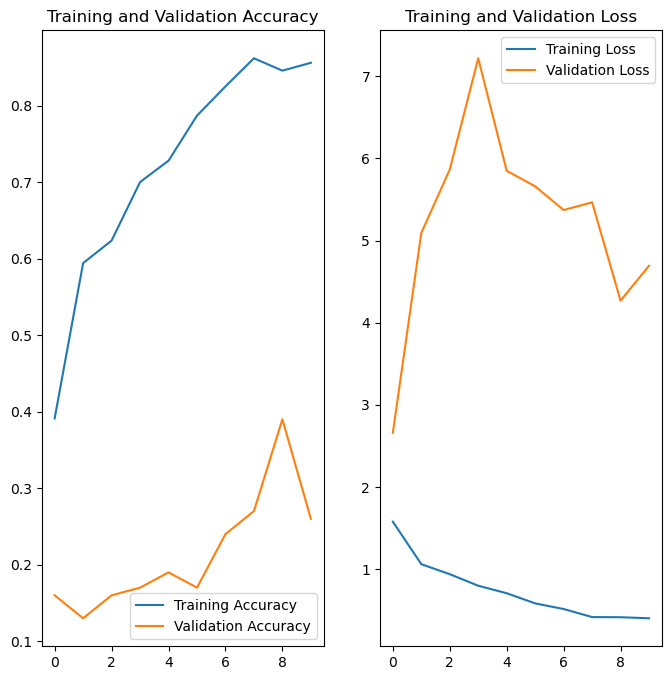

In [31]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()